<a href="https://colab.research.google.com/github/Tolu-Orina/HateSpeech/blob/main/Hate_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hate Speech Detection


### Introduction
Hate Speech is an abusive or threatening speech or writing that expresses prejudice against a particular group, especially on the basis of race, religion, or sexual orientation.

The purpose of this application and research analysis is to be able to detect hate speech including offensive language from twitter tweets. **#SayNoToHateSpeech**

### About Dataset
Dataset using Twitter data, is was used to research hate-speech detection. The text is classified as: hate-speech, offensive language, and neither. Due to the nature of the study, it’s important to note that this dataset contains text that can be considered racist, sexist, homophobic, or generally offensive.
The Dataset contains 24783 observations.

Labels in the dataset include:

* 0 - hate-speech
* 1 - offensive language
* 2 - neither

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installations

In [2]:
!pip install contractions
!pip install tensorflow-addons

     |████████████████████████████████| 287 kB 4.8 MB/s 
     |████████████████████████████████| 106 kB 49.1 MB/s 
     |████████████████████████████████| 1.1 MB 4.9 MB/s 


### Import Necessary Libraries

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from keras.layers import SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

import contractions
from textblob import TextBlob

plt.style.use("ggplot")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Exploratory Analysis

In [4]:
# Load Dataset

data = pd.read_csv("/content/drive/MyDrive/hate_speech_labeled_data.csv", index_col=0)
data = data.reset_index(drop=True)
data.tail()

,count,hate_speech,offensive_language,neither,class,tweet
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies
24782,3,0,0,3,2,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...


In [5]:
# Map class to their corresponding label
data["label"] = data["class"].map({0: "hate_speech", 1: "offensive_language", 2: "neither"})
display(data.head())

# Check the Proportion of classes Present
display(data["class"].value_counts().to_frame())

print("There is a class imbalance in the dataset, with much more of the tweets having offensive language")

,count,hate_speech,offensive_language,neither,class,tweet,label
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language


,class
1,19190
2,4163
0,1430


There is a class imbalance in the dataset, with much more of the tweets having offensive language


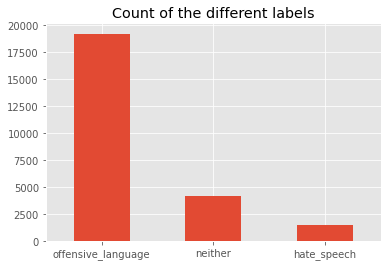

In [6]:
# Bar Plot of Labels showing imbalance
data["label"].value_counts().plot.bar(title="Count of the different labels")
plt.xticks(rotation=0)
plt.show()

### Data Preparation and Text Preprocessing

In [7]:
#  Grab the tweet and label
data2 = data[["class", "tweet", "label"]]

In [8]:
# Clean and process tweets

punct = list(string.punctuation)
punct += ['rt', 'via', '...']
stopword_list = stopwords.words("english") + punct

def clean_tweet(text, stop=False):
  """helper function for cleaning and processing tweets"""

  text = re.sub(r'&(.*?);', "", text)
  tokens = TweetTokenizer().tokenize(text=text.lower())
  tokens = [tok for tok in tokens if tok not in punct and not tok.isdigit()
                    and not tok.startswith("@") and not tok.startswith("#") and not tok.startswith("http")]

  if "you's" in tokens:
    tokens = list(map(lambda x: x.replace("you's", 'you are'), tokens))

  text = contractions.fix(' '.join(tokens))

  # Remove stopwords if true
  if stop:
    tokens = [tok for tok in text.split() if tok not in stopword_list]
    text = ' '.join(tokens)

    return text

  return text


clean_tweet(data2["tweet"][0])

'as a woman you should not complain about cleaning up your house as a man you should always take the trash out'

In [9]:
print(data.iloc[24778, :]['tweet'])

clean_tweet(data.iloc[24778, :]['tweet'])

you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8230;. Now, mine? Bible scriptures and hymns&#8221;


'you are a muthaf in lie right his tl is trash now mine bible scriptures and hymns'

In [10]:
# Load in the train, test and test_sample from earlier
train = pd.read_csv("/content/drive/MyDrive/hate_speech_train.csv")
test = pd.read_csv("/content/drive/MyDrive/hate_speech_test.csv")
test_sample = pd.read_csv("/content/drive/MyDrive/hate_speech_test_sample.csv")

In [11]:
# Apply the clean tweet function to the tweets

train['tweet2'] = train['tweet'].apply(lambda x: clean_tweet(x))
test['tweet2'] = test['tweet'].apply(lambda x: clean_tweet(x))

In [12]:
# Define the features (tweets) and the labels

X_train = train['tweet2']
X_test = test['tweet2']

y_train = pd.get_dummies(train["class"]).values
y_test = pd.get_dummies(test["class"]).values
print(y_train.shape)

# Fit texts to tokenizer
max_vocab = 50000
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(X_train)



(19802, 3)


In [13]:
# Get the vocabulary size
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(vocab_size)

17154


In [14]:
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=30)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=30)

In [15]:
# !wget -P /content/drive/MyDrive  http://nlp.stanford.edu/data/glove.6B.zip


In [16]:
# !unzip /content/drive/MyDrive/glove.6B.zip -d /content/drive/MyDrive/

### Modelling and Evaluation

In [17]:
embeddings_index = {}
# opening the downloaded glove embeddings file
f = open('/content/drive/MyDrive/glove.6B.300d.txt')
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [18]:
embedding_matrix = np.zeros((vocab_size, 300))
# Iterate through word, index in the dictionary
for word, i in word_index.items():
    # extract the corresponding vector for the vocab indice of same word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Storing it in a matrix
        embedding_matrix[i] = embedding_vector

In [22]:
# Import various layers needed for the architecture from keras

def keras_model(embedding_matrix):
  """Keras model definition"""

  # Define an embedding layer
  embedding_layer = tf.keras.layers.Embedding(vocab_size,300,weights=[embedding_matrix],
                                            input_length=30,trainable=False)

  # The Input layer 
  sequence_input = Input(shape=(30,), dtype='int32')
  # Inputs passed to the embedding layer
  embedding_sequences = embedding_layer(sequence_input)
  # dropout and conv layer 
  x = SpatialDropout1D(0.2)(embedding_sequences)
  x = Conv1D(64, 5, activation='relu')(x)
  # Passed on to the LSTM layer
  x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(512, activation='relu')(x)

  # Passed on to activation layer to get final output
  outputs = Dense(3, activation='softmax')(x)
  model = tf.keras.Model(sequence_input, outputs)

  # FBetaScore metric
  f_beta = tfa.metrics.FBetaScore(num_classes=3,average="weighted")

  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=[f_beta])
  print(model.summary())

  return model

In [23]:
# Instantiate the keras model
model_1 =  keras_model(embedding_matrix)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 300)           5146200   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 30, 300)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 64)            96064     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 512)               6604

In [25]:
X_train_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  218,
         33,    4,    1,   47,    7,   73,    6, 3093], dtype=int32)

In [26]:
# Train on all data after applying SMOTE to account for label imbalance

from imblearn.over_sampling import SMOTE

# Concatenate train and test, to develop the final model
X_all = np.concatenate((X_train_padded, X_test_padded))
y_all = np.concatenate((y_train, y_test))

sm = SMOTE()

X_balanced, y_balanced = sm.fit_resample(X_all, y_all)

# Train the keras model
history = model_1.fit(X_balanced, y_balanced, batch_size=16, epochs=10,
                    validation_split = 0.1)

Epoch 1/10
3237/3237 [==============================] - 262s 78ms/step - loss: 0.7732 - fbeta_score: 0.6338 - val_loss: 1.0136 - val_fbeta_score: 0.3546
Epoch 2/10
3237/3237 [==============================] - 248s 77ms/step - loss: 0.6334 - fbeta_score: 0.7111 - val_loss: 1.0749 - val_fbeta_score: 0.4705
Epoch 3/10
3237/3237 [==============================] - 246s 76ms/step - loss: 0.5839 - fbeta_score: 0.7341 - val_loss: 1.3635 - val_fbeta_score: 0.2439
Epoch 4/10
3237/3237 [==============================] - 245s 76ms/step - loss: 0.5540 - fbeta_score: 0.7488 - val_loss: 1.1165 - val_fbeta_score: 0.3456
Epoch 5/10
3237/3237 [==============================] - 244s 75ms/step - loss: 0.5241 - fbeta_score: 0.7616 - val_loss: 1.0484 - val_fbeta_score: 0.4828
Epoch 6/10
3237/3237 [==============================] - 245s 76ms/step - loss: 0.5068 - fbeta_score: 0.7704 - val_loss: 1.2258 - val_fbeta_score: 0.3375
Epoch 7/10
3237/3237 [==============================] - 245s 76ms/step - loss: 0.4

### Saving the Model Artifacts

In [27]:
# Splitting the model into two parts

# 1. The model structure
model_json = model_1.to_json()
with open("hate_model.json", "w") as json_file:
  json_file.write(model_json)

# 2. The model weights
model_1.save_weights("hate_weights.h5")

In [28]:
# Pickle the tokenizer
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)